In [24]:
import os
import ast
import glob
import json
import ineqpy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy import stats
from pathlib import Path

In [25]:
path_data = Path("../data")
path_meta = Path("../meta")
path_rq1 = path_meta / 'rq1'
path_rq2 = path_meta / 'rq2'

font_size = 15

platform_abbreviation_mapping = {
    'gh': 'GitHub',
    'hf': 'Hugging Face Spaces',
    'pwc': 'Papers With Code',
    'iw': 'independent platform',
}

platform_abbreviation_mapping_inverse = {v: k for k, v in platform_abbreviation_mapping.items()}

leaderboard_organization_strategies_mapping = {
    'Evaluation Configuration': ['Evaluation Dataset', 'Evaluation Metric', 'Evaluator'],
    'Leaderboard Aggregation': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Launch Date', 'Leaderboard Version'],
    'Model Capability': ['Benchmark', 'Service Load', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Engineering': ['#Prompt Example', 'Output Length', 'Prompt Design', 'Prompt Length','Tokenizer']
}

# submission_synonyms = {
#     'Instant Message': ['WeChat']
# }

macro_display_format_mapping = {
    'Table': ['Sortable Table', 'Regular Table', 'Table Screenshot'],
    'Figure': ['Bar Chart', 'Box Plot', 'Heatmap', 'Line Chart', 'Pie Chart', 'Radar Chart', 'Sortable Bar Chart', 'Scatter Plot'],
}

organizer_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy', 'Aliyun'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Bauhaus University': ['Bauhaus University Weimar'],
    'Fraunhofer Society': ['Fraunhofer Institute for Integrated Circuits'],
    'Frédéric Joliot Institute for Life Sciences': ['NeuroSpin'],
    'Google': ['Google Brain', 'Google DeepMind', 'Google Blueshift'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Max Planck Society': ['Max Planck Institute for Informatics', 'Max Planck Institute for Intelligent Systems', 'Max Planck Institute for Mathematics in the Sciences'],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'National Public School': ['National Public School HSR Layout'],
    'Naver': ['Naver Labs Europe'],
    'Queen\'s University Kingston': ['Queen\'s University'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'Toyota Technological Institute': ['Toyota Technological Institute Chicago'],
    'University of California': [
        'University of California Berkeley',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
        'University of California Irvine',
    ],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Texas': ['University of Texas Austin'],
    'University of Wisconsin': ['University of Wisconsin Madison'],
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

model_naming_convention = {
    'Model Publisher (first line)': [
        'Provider Leaderboard'
    ],
    'Repository Username': [
        'EQ-Bench (v2)',
        'HHEM Leaderboard',
        'Big Code Models Leaderboard',
        'Colossal-AI',
        'DecodingTrust',
        'LLMPerf Leaderboard',
        'LLM-Perf Leaderboard',
        'Open LLM Leaderboard',
        'Open Ko-LLM Leaderboard',
        'ScandEval'
    ],
}

# feedback_media_mapping = {
#     'GitHub': ['Issue', 'Contact'],
#     'Hugging Face Spaces': ['Discussion', 'Contact'],
#     'Papers With Code': ['Email'],
# }

display_format_pwc = ['Sortable Table', 'Scatter Plot']
dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key

macro_display_format_mapping_inverse = {v: k for k, values in macro_display_format_mapping.items() for v in values}
        
# submission_synonyms_inverse = {}
# for key, values in submission_synonyms.items():
#     for value in values:
#         submission_synonyms_inverse[value] = key

organizer_synonyms_inverse = {}
for key, values in organizer_synonyms.items():
    for value in values:
        organizer_synonyms_inverse[value] = key

leaderboard_organization_strategies_mapping_inverse = {}
for key, values in leaderboard_organization_strategies_mapping.items():
    for value in values:
        leaderboard_organization_strategies_mapping_inverse[value] = key

model_naming_convention_count = {
    k: len(v) for k, v in model_naming_convention.items()}

def convert_df_to_dict(df):
    """
    Convert a DataFrame of leaderboards and metrics to a dictionary.

    :param df: DataFrame with leaderboards and metrics
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Ensure the DataFrame's first column is considered as the keys
    # and iterate through each row to construct the dictionary
    for _, row in df.iterrows():
        key = row[0]  # The first column serves as the key
        # List comprehension to get non-empty values from the rest of the row
        values = [value for value in row[1:] if pd.notna(value)]
        leaderboard_data[key] = values

    return leaderboard_data
    # """
    # Convert a CSV file of leaderboards and metrics to a dictionary.

    # :param file_path: Path to the CSV file
    # :return: Dictionary with leaderboards as keys and list of metrics as values
    # """
    # leaderboard_data = {}

    # # Read the CSV file
    # with open(file_path, mode='r') as file:
    #     csv_reader = csv.reader(file)
    #     next(csv_reader)  # Skip the header row

    #     # Iterate through each row
    #     for row in csv_reader:
    #         if row:  # Check if row is not empty
    #             key = row[0]  # The first element is the key
    #             # List comprehension to get non-empty values
    #             values = [value for value in row[1:] if value]
    #             leaderboard_data[key] = values

    # return leaderboard_data


def string_to_list(text, platform=False):
    if pd.isna(text):
        return []
    elif platform:
        return [platform_abbreviation_mapping[platform] for platform in text.split(',')]
    else:
        return text.split(',')


def string_to_dict(s, platform=False):
    # Check if the input is np.nan
    if pd.isna(s):
        return {}
    # Split the string into key-value pairs
    pairs = s.split(',')
    result_dict = {}
    for pair in pairs:
        # Split each pair by ':' to separate keys and values
        key, value = pair.split(':')
        # Split the value by '+' to get the list of items
        value_list = value.split('+')
        # Assign the list to the key in the dictionary
        if platform:
            result_dict[platform_abbreviation_mapping[key]] = value_list
        else:
            result_dict[key] = value_list
    return result_dict


# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x


def print_empty_folders(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames:
            print(f"Empty folder: {dirpath}")


def file_rename(name, channel):
    name = name.lower()
    name = name.replace(' - ', '-')
    name = name.replace(' ', '_')
    name = name.replace(".csv", ".json")
    if channel:
        name = f'{channel}-{name}'
    return name


def process_model(model_str):
    if '](' in model_str:
        model_str = model_str.split('](')[0][1:]
        
    # Substrings to be removed
    substrings_to_remove = ['🥇', '🥈', '🥉', '🗒️', '📄', '🌍', '✨', '💙', '💚', '†', '*']
    
    # Remove each unwanted substring
    for substring in substrings_to_remove:
        model_str = model_str.replace(substring, '')
        
    return model_str.strip()
    

def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories


def organizer_synonyms_mapping(organizers):
    organizers_processed = set()
    for organizer in organizers:
        if organizer in organizer_synonyms_inverse:
            organizers_processed.add(organizer_synonyms_inverse[organizer])
        # elif 'Independent Contributor' == organizer:
        #     organizers_processed.add(leaderboard)
        else:
            organizers_processed.add(organizer)
    return list(organizers_processed)

In [21]:
xlsx = pd.ExcelFile(path_rq1 / 'Foundation Model Leaderboards.xlsx')
df = xlsx.parse('Leaderboard')

for index, row in df.iterrows():
    os.makedirs(path_data / row['Leaderboard name'], exist_ok=True) 

print_empty_folders(str(path_data))

In [26]:
directory = path_data / "GITQA"
channel = ''
drop_columns = []

for file in glob.glob(str(directory / "*.csv")):
    df = pd.read_csv(file)
    filename = file.split('/')[-1]
    filename = file_rename(filename, channel)
    df.drop(columns=drop_columns, inplace=True)
    df.to_json(directory / filename, orient="records", indent=4)
    os.remove(file)


In [28]:
# Aligning Diverse Leaderboards for Standardized Analysis 
for directory in os.listdir(path_data):
    dash = directory in dashed_model_leaderboards
    subdirectory_path = os.path.join(path_data, directory)
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        try:
            df = pd.read_json(file)
            df['Model'] = df['Model'].str.replace('_', '-') if dash else df['Model'].apply(process_model)
            df.to_json(file, orient='records', indent=4)
        except:
            print(file)


In [23]:
total_records = 0
total_leaderboards = 0
total_splits = 0

for folder in list_directories(path_data):
    total_leaderboards += 1
    prefixes = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                df = pd.read_json(file_path)
                total_records += len(df)
                total_splits += 1
                for prefix in platform_abbreviation_mapping.keys():
                    if file.startswith(prefix):
                        prefixes.append(prefix)
                        break

print(f"Total number of evaluation records: {total_records}")
print(f"Total number of leaderboards: {total_leaderboards}")
print(f"Total number of leaderboard splits: {total_splits}")

xlsx = pd.ExcelFile(path_rq1 / 'Foundation Model Leaderboards.xlsx')
df_benchmark = xlsx.parse('Benchmark')
benchmark_mapping = convert_df_to_dict(df_benchmark)
leaderboard_benchmarks = set()
for key in benchmark_mapping.keys():
    benchmarks = [benchmark if benchmark == 'ARC [Abstraction and Reasoning Corpus]' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]]
    leaderboard_benchmarks = leaderboard_benchmarks.union(set(benchmarks))
print('Total number of benchmarks:', len(leaderboard_benchmarks))


Total number of evaluation records: 55621
Total number of leaderboards: 308
Total number of leaderboard splits: 2412
Total number of benchmarks: 741


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_30600/3454049279.py:279: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [228]:
xlsx = pd.ExcelFile(path_rq1 / 'Foundation Model Leaderboards.xlsx')
df_leaderboard = xlsx.parse('Leaderboard')

df_leaderboard['Display formats (non-pwc)'] = df_leaderboard['Display formats (non-pwc)'].apply(lambda x: string_to_dict(x, platform=True))
df_leaderboard['Feedback media (iw)'] = df_leaderboard['Feedback media (iw)'].apply(string_to_list)
df_leaderboard['Host platforms'] = df_leaderboard['Host platforms'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Host platforms with leaderboard downloading functionality (non-pwc)'] = df_leaderboard['Host platforms with leaderboard downloading functionality (non-pwc)'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Host platforms with model linkage (non-pwc)'] = df_leaderboard['Host platforms with model linkage (non-pwc)'].apply(lambda x: string_to_list(x, platform=True))
df_leaderboard['Publishing organizations (non-pwc)'] = df_leaderboard['Publishing organizations (non-pwc)'].apply(string_to_list)
df_leaderboard['Publishing venues'] = df_leaderboard['Publishing venues'].apply(string_to_list)
df_leaderboard['Structuring strategies (non-pwc)'] = df_leaderboard['Structuring strategies (non-pwc)'].apply(string_to_list)
df_leaderboard['Submission artifacts (non-pwc)'] = df_leaderboard['Submission artifacts (non-pwc)'].apply(string_to_list)
df_leaderboard['Submission media (non-pwc)'] = df_leaderboard['Submission media (non-pwc)'].apply(string_to_list)
df_leaderboard['Supported languages'] = df_leaderboard['Supported languages'].apply(string_to_list)
df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(string_to_list)

df_leaderboard['Evaluated models'] = [set() for _ in range(len(df_leaderboard))]
df_leaderboard['Evaluation metrics (pwc)'] = [set() for _ in range(len(df_leaderboard))]
df_leaderboard['Structuring strategies'] = [set() for _ in range(len(df_leaderboard))]
df_leaderboard['Submission media'] = [set() for _ in range(len(df_leaderboard))]
df_leaderboard['Supported benchmarks'] = [set() for _ in range(len(df_leaderboard))]

df_benchmark = xlsx.parse('Benchmark')
benchmark_mapping = convert_df_to_dict(df_benchmark)
for key, values in benchmark_mapping.items():
    benchmark_mapping[key] = list(set([value.split(' (')[0] for value in values]))

for index, row in df_leaderboard.iterrows():
    if row['Leaderboard name'] == 'MTEB':
        benchmarks = benchmark_mapping['MTEB'] + benchmark_mapping['CMTEB']
    elif row['Leaderboard name'] in benchmark_mapping:
        benchmarks = benchmark_mapping[row['Leaderboard name']]
    else:
        benchmarks = [row['Leaderboard name'].split(' (')[0]]
    df_leaderboard.at[index, 'Supported benchmarks'] = benchmarks
    df_leaderboard.at[index, '#Supported benchmark'] = len(benchmarks)
    
    if row['Host platforms'] != ['Papers With Code']:
        df_leaderboard.at[index, '#Publishing organization (non-pwc)'] = len(organizer_synonyms_mapping(row['Publishing organizations (non-pwc)']))

    display_formats = set()
    display_formats_all = row['Display formats (non-pwc)']
    for key, values in display_formats_all.items():
        display_formats = display_formats.union(set(values))
    structuring_strategies = set(row['Structuring strategies (non-pwc)'])
    submission_artifacts = set(row['Submission artifacts (non-pwc)'])
    submission_media = set(row['Submission media (non-pwc)'])
    if 'Papers With Code' in row['Host platforms']:
        display_formats = display_formats.union(display_format_pwc)
        display_formats_all['Papers With Code'] = display_format_pwc
        structuring_strategies.add('Task')
        submission_artifacts.add('Evaluation Results')
        submission_media = submission_media.union({'Evaluation Result', 'Model Card', 'Leaderboard'})
        
    df_leaderboard.at[index, 'Structuring strategies'] = structuring_strategies
    df_leaderboard.at[index, '#Structuring strategy'] = len(structuring_strategies)
    df_leaderboard.at[index, '#Display format'] = len(display_formats)
    df_leaderboard.at[index, 'Submission artifacts'] = submission_artifacts
    df_leaderboard.at[index, 'Submission media'] = submission_media
    df_leaderboard.at[index, '#Submission medium'] = len(submission_media)
    
    df_leaderboard.at[index, '#Host platform'] = len(row['Host platforms'])
    df_leaderboard.at[index, '#Publishing venue'] = len(row['Publishing venues'])
    df_leaderboard.at[index, '#Supported language'] = len(row['Supported languages'])
    df_leaderboard.at[index, '#Supported modality'] = len(row['Supported modalities'])

    split = 0
    submission = 0
    model_names = set()
    template_metrics = set()
    
    for file in os.listdir(path_data / row['Leaderboard name']):
        host_platform = platform_abbreviation_mapping[file.split('.')[0].split('-')[0]]
        if host_platform not in row['Host platforms']:
            continue
        
        split += 1
        submission += len(df)
        
        file_path = path_data / row['Leaderboard name'] / file
        df = pd.read_json(file_path)
        
        if row['Leaderboard name'] in model_naming_convention['Repository Username']:
            df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
        try:
            df['Model'] = df['Model'].apply(lambda x: x.split('\n')[0].split('(')[0].strip())
        except:
            print(row['Leaderboard name'])
        model_names = model_names.union(set(df['Model']))
        
        file_name = file.split('/')[-1]
        if file_name.startswith('pwc'):
            keys = set()
            for item in df['metrics']:
                for key in item.keys():
                    key_processed = key.split('(')[0].lower().strip()
                    if key_processed in metrics_synonyms_inverse:
                        keys.add(metrics_synonyms_inverse[key_processed])
                    else:
                        keys.add(key_processed)
            template_metrics = template_metrics.union(keys)
    
    df_leaderboard.at[index, '#Evaluation record'] = submission
    df_leaderboard.at[index, '#Evaluated model'] = len(model_names)
    df_leaderboard.at[index, 'Evaluated models'] = list(model_names)
    if split:
        df_leaderboard.at[index, '#Leaderboard split'] = split
    if template_metrics:
        df_leaderboard.at[index, '#Evaluation metric (pwc)'] = len(template_metrics)
        df_leaderboard.at[index, 'Evaluation metrics (pwc)'] = list(template_metrics)
        
df_leaderboard.to_csv(path_rq1 / 'leaderboard_processed.csv', index=False)


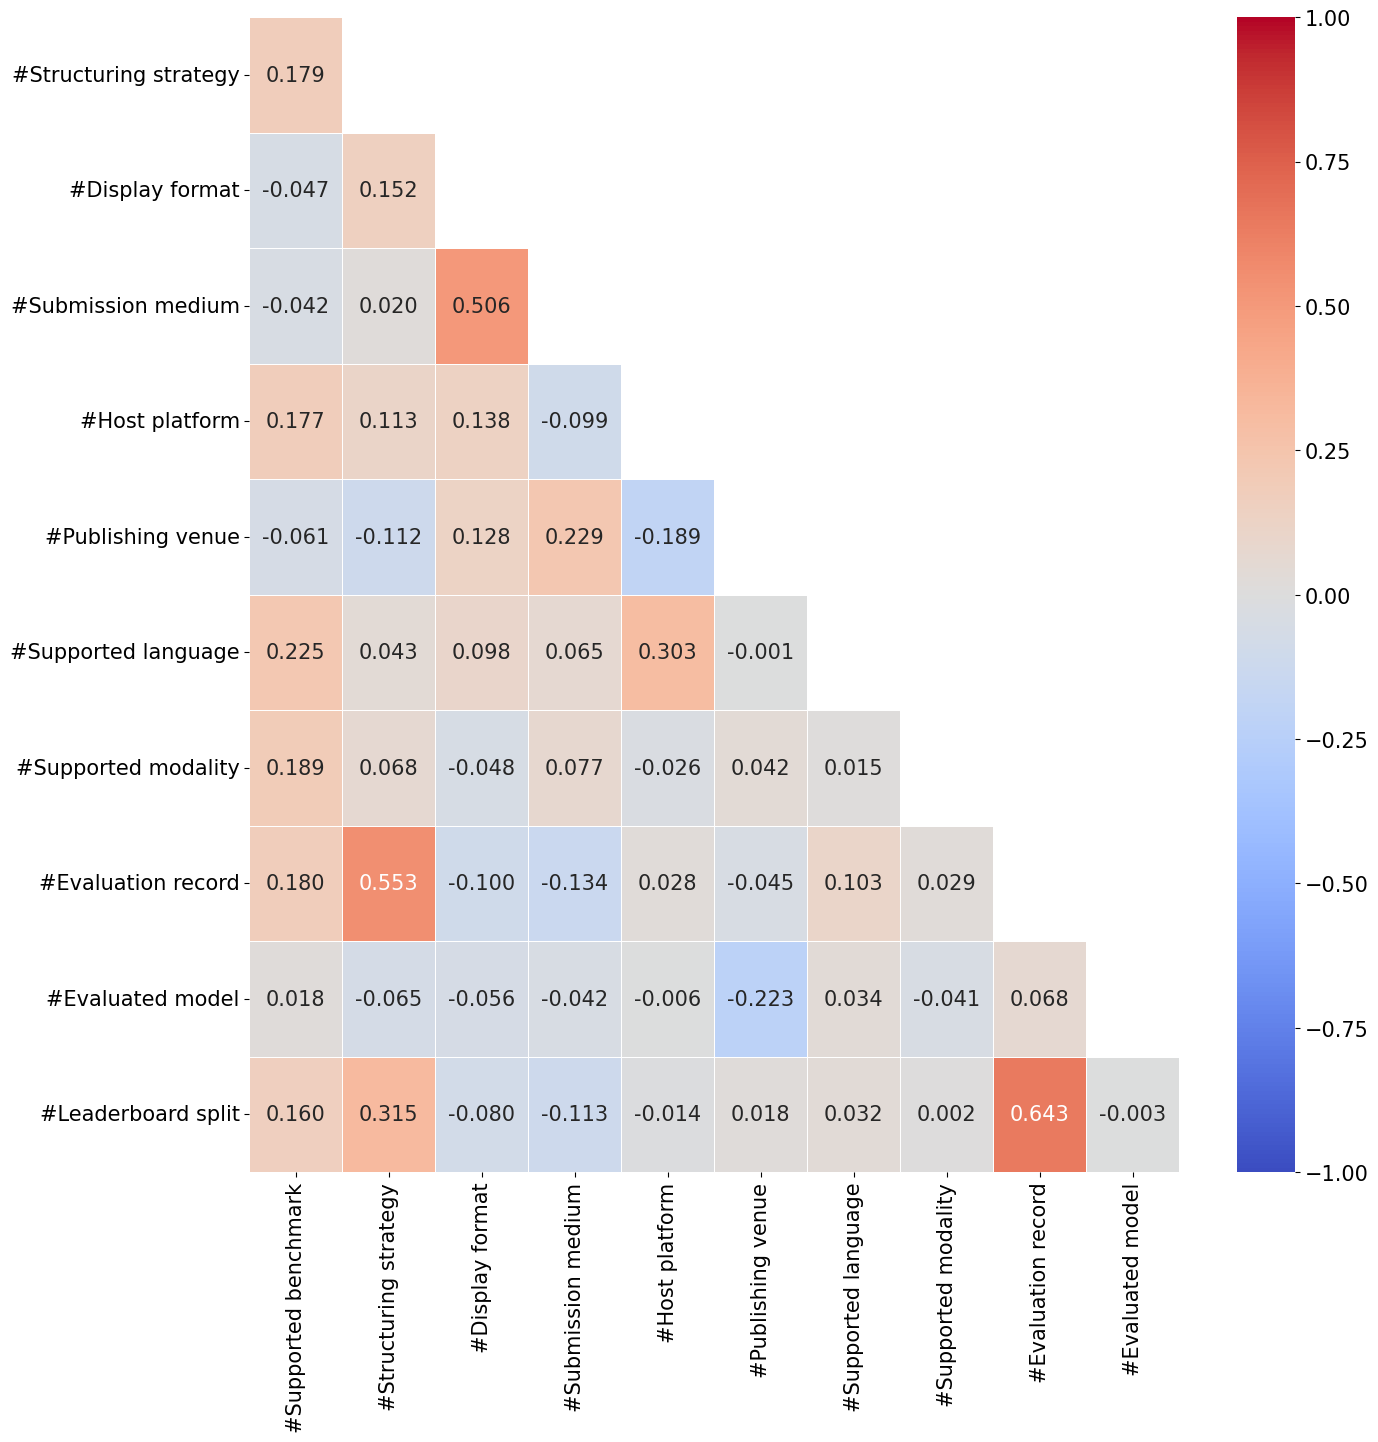

In [240]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['#Evaluation metric (pwc)', '#Publishing organization (non-pwc)'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, mask=mask, vmin=-1, vmax=1, annot_kws={"size": font_size})
# Enlarge axis font size
ax.tick_params(axis='both', which='major', labelsize=font_size)
# Adjust color bar (color scale) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font_size)  # Adjusts the tick labels' font size

# plt.title('Correlation Matrix Heatmap for Leaderboard Attributes')
plt.savefig(path_rq1 / 'leaderboard-attribute-heatmap.pdf', format='pdf')
plt.show()


In [206]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Structuring strategies'].map(len) > 0]
print(f"{len(df[df['#Empty leaderboards (non-pwc)'].notna()])} multi-scenario leaderboards (excluding Papers With Code) have missing scenarios, accounting for {round(len(df[df['#Empty leaderboards (non-pwc)'].notna()])/len(df)*100,2)}% of the total.")
df['#Empty leaderboards (non-pwc)'].value_counts().reset_index(name='Frequency')

4 multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for 1.21% of the total.


,#Empty leaderboards (non-pwc),Frequency
0,2,2
1,?,2


Regular Table is the most prevalent display format in leaderboards hosted on GitHub, accounting for 71.43% (70 out of 98) leaderboards.
Sortable Table is the most prevalent display format in leaderboards hosted on Hugging Face, accounting for 93.75% (30 out of 32) leaderboards.
Sortable Table is the most prevalent display format in leaderboards hosted on PapersWithCode, accounting for 100.0% (165 out of 165) leaderboards.
Sortable Table is the most prevalent display format in leaderboards hosted on independent website, accounting for 69.01% (49 out of 71) leaderboards.


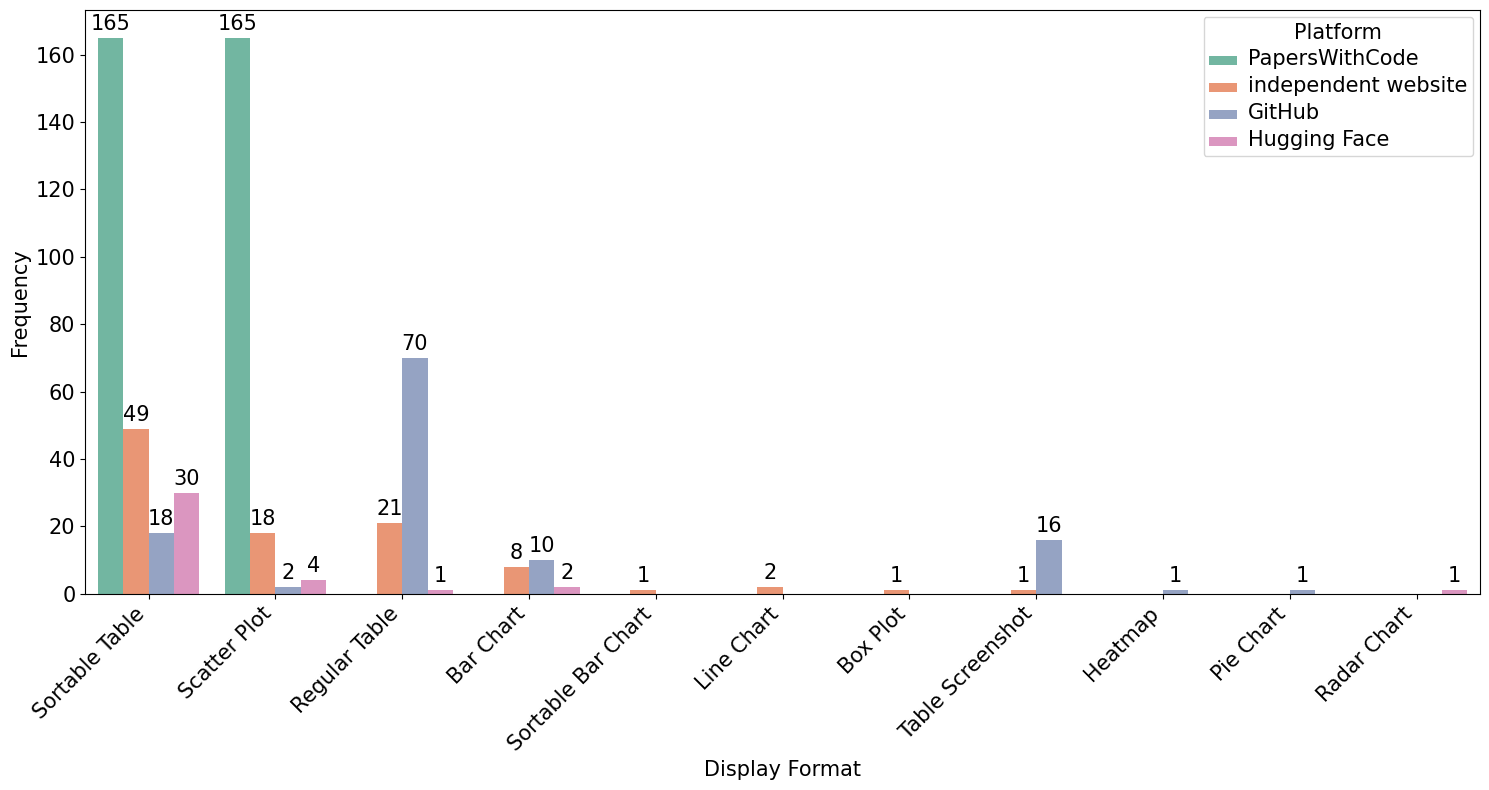

In [212]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Display formats (non-pwc)'] = df['Display formats (non-pwc)'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)

format_counts = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    # Loop through each platform and its formats in the dictionary
    for platform, formats in row['Display formats (non-pwc)'].items():
        for format_type in formats:
            # Increment the count for the format type under its respective platform
            format_counts[platform][format_type] += 1
            
flattened_data = []
for platform, formats in format_counts.items():
    for format_type, count in formats.items():
        flattened_data.append({'Platform': platform, 'Display Format': format_type, 'Frequency': count})
        
df_display = pd.DataFrame(flattened_data)
df = df.explode('Host platforms')
for name, group in df_display.groupby('Platform'):
    group = group.sort_values(by='Frequency', ascending=False)
    print(f"{group['Display Format'].iloc[0]} is the most prevalent display format in leaderboards hosted on {name}, accounting for {round(group['Frequency'].iloc[0]/len(df[df['Host platforms'] == name])*100,2)}% ({group['Frequency'].iloc[0]} out of {len(df[df['Host platforms'] == name])}) leaderboards.")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust figure size as needed
ax = sns.barplot(
    x='Display Format', 
    y='Frequency', 
    hue='Platform',  # This separates the bars within each group by platform
    data=df_display, 
    palette='Set2',  # Choose a palette that makes the bars distinct
    dodge=True  # Adjust this to control the gap between bars of different platforms within the same group
)

# Setting the title and labels with enlarged fonts
ax.set_xlabel('Display Format', fontsize=font_size)  # Enlarge x-axis label
ax.set_ylabel('Frequency', fontsize=font_size)  # Enlarge y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Enlarge axis ticks font size
ax.tick_params(axis='both', which='major', labelsize=font_size)

# Adding annotations on top of each bar
for p in ax.patches:
    if p.get_height():
        ax.annotate(format(p.get_height(), '.0f'),  # Format the number displayed
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar
                textcoords = 'offset points', fontsize=font_size)

# Adjust the legend
leg = ax.legend(title='Platform')
leg.set_title('Platform', prop={'size':font_size})  # Set the title font size
for text in leg.get_texts():  # Set the font size for each legend text
    text.set_fontsize(font_size)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# Save the plot to a PDF file
plt.savefig(path_rq1 / 'display-format-distribution.pdf', bbox_inches='tight')
plt.show()

df_sum = df_display.groupby('Display Format').sum().reset_index()
df_sum['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Display Formats',
    'Mean': np.mean(df_sum['Frequency']),
    'Median': np.median(df_sum['Frequency']),
    'Mode': stats.mode(df_sum['Frequency'])[0],
    'Standard Deviation': np.std(df_sum['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_sum, income='Frequency', weights='Weight'),
}
if os.path.exists(path_rq1 / 'leaderboard_statistics.csv'):
    df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
else:
    df_statistics = pd.DataFrame()
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)


In [7]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Display Formats across Leaderboards',
    'Mean': np.mean(df['#Display format']),
    'Median': np.median(df['#Display format']),
    'Mode': stats.mode(df['#Display format'])[0],
    'Standard Deviation': np.std(df['#Display format']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Display format', ascending=False).head(15)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of display formats up to {int(df_top['#Display format'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Display format'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Display format'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Display Format',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Models Leaderboard supports the highest number of display formats up to 5.


In [6]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
print(f"{round(len(df[df['Host platforms'].map(len) > 1])/len(df)*100,2)}% ({len(df[df['Host platforms'].map(len) > 1])} out of {len(df)}) leaderboards are hosted on multiple platforms.")

df_split = df.explode('Host platforms')['Host platforms'].value_counts().reset_index(name='Frequency')
print(f"{df_split['Host platforms'].iloc[0]} is the most popular host platform, accounting for {round(df_split['Frequency'].iloc[0]/len(df)*100,2)}% ({df_split['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Host Platforms',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_split['Host platforms'],
    y=df_split['Frequency'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Number of Leaderboards'},
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

9.67% (32 out of 331) leaderboards are hosted on multiple platforms.
PapersWithCode is the most popular host platform, accounting for 49.85% (165 out of 331) leaderboards.


In [111]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Host Platforms across Leaderboards',
    'Mean': np.mean(df['#Host platform']),
    'Median': np.median(df['#Host platform']),
    'Mode': stats.mode(df['#Host platform'])[0],
    'Standard Deviation': np.std(df['#Host platform']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Host platform', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} is hosted by the highest number of platforms up to {int(df_top['#Host platform'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Host platform'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Host platform'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Host Platforms',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

MTEB is hosted by the highest number of platforms up to 4.


In [205]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Host platforms'] != "['Papers With Code']"]

df['Publishing organizations (non-pwc)'] = df['Publishing organizations (non-pwc)'].apply(ast.literal_eval)
df_split = df.explode('Publishing organizations (non-pwc)').groupby('Publishing organizations (non-pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Publishing Organizations (non-pwc)',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Publishing organizations (non-pwc)'].iloc[0]} is the most productive publisher among the {len(df)} publishers, accounting for {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Publishing organizations (non-pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards across Publishing organizations (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


Allen Institute for AI is the most productive publisher among the 170 publishers, accounting for 13.53% (23 out of 170) leaderboards.


In [145]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Host platforms'] != "['Papers With Code']"]

statistics = {
    'Distribution|Property': 'Publishing Organizations across Leaderboards (non-pwc)',
    'Mean': np.mean(df['#Publishing organization (non-pwc)']),
    'Median': np.median(df['#Publishing organization (non-pwc)']),
    'Mode': stats.mode(df['#Publishing organization (non-pwc)'])[0],
    'Standard Deviation': np.std(df['#Publishing organization (non-pwc)']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Publishing organization (non-pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the highest number of publishing organizations up to {int(df_top['#Publishing organization (non-pwc)'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Publishing organization (non-pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Publishing organization (non-pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Publishing Organization',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


TrustLLM holds the highest number of publishing organizations up to 36.


In [88]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df_pub = df[df['#Publishing venue'] > 0]
print(f"{round(len(df_pub)/len(df)*100,2)}% ({len(df_pub)} out of {len(df)}) leaderboards are associated with specific publications, including articles, preprints, and reports.")

df_pub['Publishing venues'] = df_pub['Publishing venues'].apply(ast.literal_eval)
df_accepted = df_pub[df_pub['Publishing venues'].apply(lambda x: 'Preprint' not in x)]
print(f"{round(len(df_accepted)/len(df)*100,2)}%  ({len(df_accepted)} out of {len(df_pub)}) articles have been accepted in a specific workshop, conference, and journal.")

df_split = df_accepted.explode('Publishing venues').groupby('Publishing venues').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Publishing Venues',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Publishing venues'].iloc[0]} emerges as the conference with the most number of accepted articles, accounting for {round(df_top['Frequency'].iloc[0]/len(df_accepted)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_accepted)}) of the total.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Publishing venues'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards with Accepted Articles across Publishing Venues (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publication Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.show()


90.03% (298 out of 331) leaderboards are associated with specific publications, including articles, preprints, and reports.
58.01%  (192 out of 298) articles have been accepted in a specific workshop, conference and journal.
EMNLP emerges as the conference with most number of accepted articles, accounting for 15.62% (30 out of 192) of the total.


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_956/3459455601.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df_split = df[df['#Structuring strategy'] > 0]
print(f'{round(len(df_split)/len(df)*100,2)}% ({len(df_split)} out of {len(df)}) leaderboards have adopted multiple structuring strategies.')

statistics = {
    'Distribution|Property': 'Structuring Strategies across Leaderboards',
    'Mean': np.mean(df_split['#Structuring strategy']),
    'Median': np.median(df_split['#Structuring strategy']),
    'Mode': stats.mode(df_split['#Structuring strategy'])[0],
    'Standard Deviation': np.std(df_split['#Structuring strategy']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Structuring strategy', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has adopted the highest number of structuring strategies up to {int(df_top['#Structuring strategy'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Structuring strategy'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Structuring strategy'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Structuring Strategy',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


74.62% (247 out of 331) leaderboards have adopted multiple structuring strategies.
HELM Classic has adopted the highest number of structuring strategies up to 10.


In [3]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df_split = df[df['#Structuring strategy'] > 0]
print(f'{round(len(df_split)/len(df)*100,2)}% ({len(df_split)} out of {len(df)}) leaderboards have adopted multiple structuring strategies.')

df_split['Structuring strategies'] = df_split['Structuring strategies'].apply(ast.literal_eval)
df_split2 = df_split.explode('Structuring strategies').groupby('Structuring strategies').size().reset_index(name='Frequency')
df_split2['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Structuring Strategies',
    'Mean': np.mean(df_split2['Frequency']),
    'Median': np.median(df_split2['Frequency']),
    'Mode': stats.mode(df_split2['Frequency'])[0],
    'Standard Deviation': np.std(df_split2['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split2, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split2.sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Structuring strategies'].iloc[0]} is the most adopted structuring strategies, covering {round(df_top['Frequency'].iloc[0]/len(df_split)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df_split)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Structuring strategies'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Structuring Strategy',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


74.62% (247 out of 331) leaderboards have adopted multiple structuring strategies.
Task is the most adopted structuring strategies, covering 78.95% (195 out of 247) leaderboards.


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_30600/2659376548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split['Structuring strategies'] = df_split['Structuring strategies'].apply(ast.literal_eval)


In [65]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Supported Languages across Leaderboards',
    'Mean': np.mean(df['#Supported language']),
    'Median': np.median(df['#Supported language']),
    'Mode': stats.mode(df['#Supported language'])[0],
    'Standard Deviation': np.std(df['#Supported language']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported language', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of languages up to {int(df_top['#Supported language'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported language'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported language'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Languages',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


MTEB supports the highest number of languages up to 112.


In [66]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)

df_split = df.explode('Supported languages').groupby('Supported languages').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Supported Languages',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported languages']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported languages'].iloc[0]} is the most supported language in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported languages'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported language',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

English is the most supported language by 89.43% (296 out of 331) leaderboards.


In [67]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Supported Modalities across Leaderboards',
    'Mean': np.mean(df['#Supported modality']),
    'Median': np.median(df['#Supported modality']),
    'Mode': stats.mode(df['#Supported modality'])[0],
    'Standard Deviation': np.std(df['#Supported modality']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported modality', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of modality up to {int(df_top['#Supported modality'].iloc[0])}.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported modality'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported modality'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Modality',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


FlagEval supports the highest number of modality up to 4.


In [68]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)

df_split = df.explode('Supported modalities').groupby('Supported modalities').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Supported Modalities',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported modalities']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported modalities'].iloc[0]} is the most supported modality by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported modalities'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported Modality',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

Text is the most supported modality by 100.0% (331 out of 331) leaderboards.


In [75]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Supported Benchmarks across Leaderboards',
    'Mean': np.mean(df['#Supported benchmark']),
    'Median': np.median(df['#Supported benchmark']),
    'Mode': stats.mode(df['#Supported benchmark'])[0],
    'Standard Deviation': np.std(df['#Supported benchmark']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Supported benchmark', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} supports the highest number of {int(df_top['#Supported benchmark'].iloc[0])} benchmarks.")

fig = go.Figure(go.Bar(
        x=df_top['#Supported benchmark'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Supported benchmark'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Supported Benchmarks',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


BIG-Bench supports the highest number of 209 benchmarks.


In [74]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Supported benchmarks'] = df['Supported benchmarks'].apply(ast.literal_eval)

df_split = df.explode('Supported benchmarks').groupby('Supported benchmarks').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Supported Benchmarks',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Supported benchmarks']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Supported benchmarks'].iloc[0]} is the most supported benchmark by {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Supported benchmarks'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Supported Benchmark',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

MMLU is the most supported benchmark by 4.83% (16 out of 331) leaderboards.


In [73]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Evaluated Models across Leaderboards',
    'Mean': np.mean(df['#Evaluated model']),
    'Median': np.median(df['#Evaluated model']),
    'Mode': stats.mode(df['#Evaluated model'])[0],
    'Standard Deviation': np.std(df['#Evaluated model']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluated model', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluated model'].iloc[0])} models evaluated.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluated model'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluated model'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluated Models',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


Open LLM Leaderboard has the highest number of 4057 models evaluated.


In [72]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Evaluated models'] = df['Evaluated models'].apply(ast.literal_eval)

df_split = df.explode('Evaluated models').groupby('Evaluated models').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Evaluated Models',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluated models']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluated models'].iloc[0]} is the most widely evaluated model in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluated models'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluated Model',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

GPT-4 is the most prevalent model evaluated in 16.01% (53 out of 331) leaderboards.


In [71]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Host platforms'] == "['Papers With Code']"]

statistics = {
    'Distribution|Property': 'Evaluation Metrics across Leaderboards (pwc)',
    'Mean': np.mean(df['#Evaluation metric (pwc)']),
    'Median': np.median(df['#Evaluation metric (pwc)']),
    'Mode': stats.mode(df['#Evaluation metric (pwc)'])[0],
    'Standard Deviation': np.std(df['#Evaluation metric (pwc)']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation metric (pwc)', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation metric (pwc)'].iloc[0])} evaluation metrics.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation metric (pwc)'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation metric (pwc)'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Metrics',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


MSCOCO has the highest number of 19 evaluation metrics.


In [70]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Host platforms'] == "['Papers With Code']"]
df['Evaluation metrics (pwc)'] = df['Evaluation metrics (pwc)'].apply(ast.literal_eval)

df_split = df.explode('Evaluation metrics (pwc)').groupby('Evaluation metrics (pwc)').size().reset_index(name='Frequency')
df_split['Weight'] = 1

statistics = {
    'Distribution|Property': 'Leaderboards across Evaluation Metrics (pwc)',
    'Mean': np.mean(df_split['Frequency']),
    'Median': np.median(df_split['Frequency']),
    'Mode': stats.mode(df_split['Frequency'])[0],
    'Standard Deviation': np.std(df_split['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_split, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df_split.drop_duplicates(subset=['Evaluation metrics (pwc)']).sort_values(by='Frequency', ascending=False).head(10)
print(f"{df_top['Evaluation metrics (pwc)'].iloc[0]} is the most prevalent evaluation metrics in {round(df_top['Frequency'].iloc[0]/len(df)*100,2)}% ({df_top['Frequency'].iloc[0]} out of {len(df)}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['Frequency'],  # Values for the bar lengths
        y=df_top['Evaluation metrics (pwc)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['Frequency'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Leaderboard Number',
        yaxis_title='Evaluation Metric',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()

accuracy is the most prevalent evaluation metrics in 45.34% (73 out of 161) leaderboards.


In [5]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['#Leaderboard split'] > 0]

statistics = {
    'Distribution|Property': 'Splits across Multi-split Leaderboards',
    'Mean': np.mean(df['#Leaderboard split']),
    'Median': np.median(df['#Leaderboard split']),
    'Mode': stats.mode(df['#Leaderboard split'])[0],
    'Standard Deviation': np.std(df['#Leaderboard split']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Leaderboard split', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Leaderboard split'].iloc[0])} leaderboard splits.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard split'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard split'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Split Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


LMExamQA has the highest number of 887 leaderboard splits.


In [61]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Weight'] = 1

statistics = {
    'Distribution|Property': 'Evaluation Records across Leaderboards',
    'Mean': np.mean(df['#Evaluation record']),
    'Median': np.median(df['#Evaluation record']),
    'Mode': stats.mode(df['#Evaluation record'])[0],
    'Standard Deviation': np.std(df['#Evaluation record']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df, income='#Evaluation record', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Evaluation record', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Evaluation record'].iloc[0])} evaluation records.")

fig = go.Figure(go.Bar(
        x=df_top['#Evaluation record'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Evaluation record'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Evaluation Records',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


HELM Classic has the highest number of 16005 evaluation records.


In [131]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Host platforms'] != "['Papers With Code']"]
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)

df['Host platforms with model linkage (non-pwc)'] = df['Host platforms with model linkage (non-pwc)'].apply(ast.literal_eval)
df_provenance = df[df['Host platforms with model linkage (non-pwc)'].map(len) > 0]
print(f"{round(len(df_provenance)/len(df)*100,2)}% ({len(df_provenance)} out of {len(df)}) leaderboards hosted on other platforms provide accessible links to the provenance information of the evaluated models.")
df_split = df_provenance.explode('Host platforms with model linkage (non-pwc)')
df_split = df_split['Host platforms with model linkage (non-pwc)'].value_counts().reset_index(name='Frequency')

total_data = 0
total_provenance = 0
for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.startswith('pwc') and file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as file:
                json_data = json.load(file)
                total_data += len(json_data)
                json_external = [external for external in json_data if type(external['external_source_url']) == str]
                total_provenance += len(json_external)
                if not len(json_external):
                    json_internal = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    total_provenance += len(json_internal)
print(f'For Papers With Code leaderboards, the overall provenance rate across all leaderboards is {round(total_provenance/total_data*100, 2)}%, equivalent to {total_provenance} out of {total_data} evaluation records.')

fig = px.bar(
    x=df_split['Host platforms with model linkage (non-pwc)'],
    y=df_split['Frequency'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Number of Leaderboards with Model Provenance Linkage across Platforms (non-pwc)'
)
fig.show()


48.82% (83 out of 170) leaderboards provide accessible links to the provenance information of the evaluated models.
For leaderboards hosted on PapersWithCode, the overall provenance rate across all leaderboards stands at 98.03%, equating to 7280 out of 7426 evaluation records.


In [186]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Submission media'] = df['Submission media'].apply(ast.literal_eval)

df_submission = df[df['Submission media'].map(len) > 0]
print(f"{round(len(df_submission)/len(df)*100,2)}% ({len(df_submission)} out of {len(df)}) leaderboards provide at least one submission guideline for new evaluation records.")

df_media = df_submission.explode('Submission media')
df_media = df_media['Submission media'].value_counts().reset_index(name='Frequency')
df_media['Weight'] = 1
print(f"{df_media['Submission media'].iloc[0]} is the most prevalent submission media, accounting for {round(df_media['Frequency'].iloc[0]/len(df_submission)*100,2)}% ({df_media['Frequency'].iloc[0]} out of {len(df_submission)}) leaderboards.")

statistics = {
    'Distribution|Property': 'Leaderboards across Submission Media',
    'Mean': np.mean(df_media['Frequency']),
    'Median': np.median(df_media['Frequency']),
    'Mode': stats.mode(df_media['Frequency'])[0],
    'Standard Deviation': np.std(df_media['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_media, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_media['Submission media'], 
    y=df_media['Frequency'],
    text_auto=True,
    labels={'x': 'Submission Medium', 'y': 'Leaderboard Number'},
    title='Number of Leaderboards across Submission Media'
)
fig.write_image(path_rq1 / 'submission-media-distribution.pdf')
fig.show()

79.15% (262 out of 331) leaderboards provide at least one submission guideline of new evaluation records.
Model Card is the most prevalent submission media, accounting for 63.36% (166 out of 262) leaderboards.


In [182]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')

statistics = {
    'Distribution|Property': 'Submission Media across Leaderboards',
    'Mean': np.mean(df['#Submission medium']),
    'Median': np.median(df['#Submission medium']),
    'Mode': stats.mode(df['#Submission medium'])[0],
    'Standard Deviation': np.std(df['#Submission medium']),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

df_top = df.drop_duplicates(subset=['Leaderboard name']).sort_values(by='#Submission medium', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} has the highest number of {int(df_top['#Submission medium'].iloc[0])} submission media.")

fig = go.Figure(go.Bar(
        x=df_top['#Submission medium'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Submission medium'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        xaxis_title='Number of Submission Medium',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# Update the layout for a tighter look
fig.update_layout(
    autosize=True,
    margin=dict(
        l=10,  # Left margin
        r=10,  # Right margin
        b=10,  # Bottom margin
        t=10,  # Top margin
        pad=4  # Padding between the plot and the margin
    )
)
fig.show()


CORE-MM has the highest number of 3 submission media.


In [236]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df['Submission artifacts'] = df['Submission artifacts'].apply(ast.literal_eval)

df_submission = df[df['Submission artifacts'].map(len) > 0]
df_artifact = df_submission.explode('Submission artifacts')
df_artifact = df_artifact['Submission artifacts'].value_counts().reset_index(name='Frequency')
df_artifact['Weight'] = 1
print(f"{df_artifact['Submission artifacts'].iloc[0]} is the most prevalent submission artifact, accounting for {round(df_artifact['Frequency'].iloc[0]/len(df_submission)*100,2)}% ({df_artifact['Frequency'].iloc[0]} out of {len(df_submission)}) leaderboards.")

statistics = {
    'Distribution|Property': 'Leaderboards across Submission Artifacts',
    'Mean': np.mean(df_media['Frequency']),
    'Median': np.median(df_media['Frequency']),
    'Mode': stats.mode(df_media['Frequency'])[0],
    'Standard Deviation': np.std(df_media['Frequency']),
    'Gini Coefficient': ineqpy.inequality.gini(data=df_media, income='Frequency', weights='Weight'),
}
df_statistics = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df_statistics = pd.concat([df_statistics, pd.DataFrame([statistics])], ignore_index=True)
df_statistics.drop_duplicates(subset=['Distribution|Property'], keep='last', inplace=True)
df_statistics.sort_values(by='Distribution|Property', inplace=True)
df_statistics.to_csv(path_rq1 / 'leaderboard_statistics.csv', index=False)

fig = px.bar(
    x=df_artifact['Submission artifacts'],
    y=df_artifact['Frequency'],
    text_auto=True,
    labels={'x': 'Submission Artifact', 'y': 'Leaderboard Number'},
    title='Number of Leaderboards across Submission Artifacts'
)
fig.update_layout(xaxis_tickangle=-45)
fig.write_image(path_rq1 / 'submission-artifact-distribution.pdf')
fig.show()

Evaluation Results is the most prevalent submission artifact, accounting for 66.03% (173 out of 262) leaderboards.


In [234]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df = df[df['Host platforms'].str.contains('independent platform')]
print(f'There are {len(df)} leaderboards hosted on independent platforms.')

df = df[df['Host platforms'] == "['independent platform']"]
print(f'There are {len(df)} leaderboards exclusively hosted on independent platforms.')

df['Feedback media (iw)'] = df['Feedback media (iw)'].apply(ast.literal_eval)
df_provenance = df[df['Feedback media (iw)'].map(len) > 0]
print(f"{round(len(df_provenance)/len(df)*100,2)}% leaderboards hosted on independent platforms offer feedback mechanisms, with only {len(df)-len(df_provenance)} exception.")

df_provenance = df_provenance.explode('Feedback media (iw)')['Feedback media (iw)'].value_counts().reset_index(name='Frequency')
df_provenance

There are 71 leaderboards hosted on independent websites.
There are 51 leaderboards exclusively hosted on independent websites.
98.04% leaderboards hosted on independent websites offer feedback mechanisms, with only 1 exception.


,Feedback media (iw),Frequency
0,Contact,50
1,Issue,21


In [237]:
df = pd.read_csv(path_rq1 / 'leaderboard_processed.csv')
df_structure = df[df['#Structuring strategy'] > 0]
print(f'There are {len(df_structure)} leaderboards that have adopted structuring strategies, accounting for {round(len(df_structure)/len(df)*100,2)}% of the total.')
df_structure['Structuring strategies'] = df_structure['Structuring strategies'].apply(ast.literal_eval)
df_split = df_structure.explode('Structuring strategies')

df_number = pd.DataFrame()
for index, (name, group) in enumerate(df_split.groupby('Structuring strategies')):
    entry = {
        'Index': index, # Temporarily store the original index
        'Major category': leaderboard_organization_strategies_mapping_inverse[name],
        'Structuring strategy': name,
        'Prevalence (%)': len(group)/len(df_structure)*100,
    }
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

df_number = df_number.sort_values(by=['Major category', 'Structuring strategy']).reset_index(drop=True)
df_number['Index'] = df_number.index + 1
df_number['Index'] = df_number['Index'].apply(lambda x: f'$C_{{0{x}}}$' if x < 10 else f'$C_{{{x}}}$')
print(df_number.to_latex(float_format="%.2f", index=False))

df_split['Major structuring strategy'] = df_split['Structuring strategies'].map(leaderboard_organization_strategies_mapping_inverse)
df_split2 = df_split['Major structuring strategy'].value_counts().reset_index(name='Frequency')
fig = px.bar(
    title='Distribution of Leaderboards across Major Structuring Strategies',
    x=df_split2['Major structuring strategy'],
    y=df_split2['Frequency'],
    text_auto=True,
    labels={'x': 'Major Structuring Strategy', 'y': 'Leaderboard Number'},
)
fig.show()

There are 247 leaderboards that have adopted structuring strategies, accounting for 74.62% of the total.
\begin{tabular}{lllr}
\toprule
Index & Major category & Structuring strategy & Prevalence (%) \\
\midrule
$C_{01}$ & Evaluation Configuration & Evaluation Dataset & 5.67 \\
$C_{02}$ & Evaluation Configuration & Evaluation Metric & 4.45 \\
$C_{03}$ & Evaluation Configuration & Evaluator & 2.02 \\
$C_{04}$ & Leaderboard Aggregation & Aggregated Result & 11.34 \\
$C_{05}$ & Leaderboard Release & Leaderboard Launch Date & 0.81 \\
$C_{06}$ & Leaderboard Release & Leaderboard Version & 1.21 \\
$C_{07}$ & Model Capability & Benchmark & 4.86 \\
$C_{08}$ & Model Capability & Service Load & 1.62 \\
$C_{09}$ & Model Capability & Supported Functionality & 8.91 \\
$C_{10}$ & Model Capability & Supported Language & 3.64 \\
$C_{11}$ & Model Capability & Supported Modality & 1.21 \\
$C_{12}$ & Model Capability & Task & 78.95 \\
$C_{13}$ & Model Information & Model Accessibility & 2.02 \\
$C_{14}$ &

/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_956/2405965500.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
df = pd.read_csv(path_rq1 / 'leaderboard_statistics.csv')
df.fillna('', inplace=True)
df['Mean'] = df['Mean'].map('{:.2f}'.format)
df['Median'] = df['Median'].map('{:.2f}'.format)
df['Standard Deviation'] = df['Standard Deviation'].map('{:.2f}'.format)
df['Gini Coefficient'] = df['Gini Coefficient'].map(lambda x: '{:.3f}'.format(x) if x else x)
df['Mode'] = df['Mode'].map('{:.0f}'.format)
print(df.to_latex(index=False))

\begin{tabular}{llllll}
\toprule
Distribution|Property & Mean & Median & Mode & Standard Deviation & Gini Coefficient \\
\midrule
Display Formats across Leaderboards & 1.72 & 2.00 & 2 & 0.56 &  \\
Evaluated Models across Leaderboards & 50.29 & 16.00 & 4 & 241.55 &  \\
Evaluation Metrics across Leaderboards (pwc) & 3.07 & 2.00 & 1 & 3.05 &  \\
Evaluation Records across Leaderboards & 167.54 & 25.00 & 4 & 1009.87 & 0.859 \\
Host Platforms across Leaderboards & 1.11 & 1.00 & 1 & 0.34 &  \\
Leaderboards across Display Formats & 53.36 & 2.00 & 1 & 86.45 & 0.812 \\
Leaderboards across Evaluated Models & 1.34 & 1.00 & 1 & 1.25 & 0.224 \\
Leaderboards across Evaluation Metrics (pwc) & 2.20 & 1.00 & 1 & 5.23 & 0.488 \\
Leaderboards across Host Platforms & 91.50 & 84.50 & 32 & 48.49 & 0.388 \\
Leaderboards across Publishing Organizations (non-pwc) & 2.38 & 1.00 & 1 & 2.99 & 0.469 \\
Leaderboards across Publishing Venues & 4.33 & 1.00 & 1 & 6.33 & 0.626 \\
Leaderboards across Structuring Strategi

/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_30600/1015774637.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

